## Initial set up of containers and so on

In [1]:
%pip install docker pymongo dask[complete] graphviz

  Using cached partd-1.1.0-py3-none-any.whl (19 kB)
     |████████████████████████████████| 19.3 MB 13.1 MB/s eta 0:00:01    |█                               | 573 kB 13.1 MB/s eta 0:00:02
  Using cached locket-0.2.0.tar.gz (3.5 kB)
Using legacy setup.py install for bokeh, since package 'wheel' is not installed.
Using legacy setup.py install for locket, since package 'wheel' is not installed.
    Running setup.py install for locket ... done
    Running setup.py install for bokeh ... done
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import docker

docker_client = docker.from_env()

mongo_container = docker_client.containers.run(
    'mongo:latest',
    detach=True,
    name='mongo-data-prep',
    remove=True,
    ports={'27017/tcp': 27018},
    mem_limit='512M',
    volumes={
        os.path.join(os.getcwd(), 'db'): {'bind': '/data/db', 'mode': 'rw'},
        os.path.join(os.getcwd(), 'mongo.conf'): {'bind': '/etc/mongo.conf', 'mode': 'ro'}
    }
)

In [2]:
mongo_container.logs()

b'2020-06-17T07:09:48.388+0000 I  CONTROL  [main] Automatically disabling TLS 1.0, to force-enable TLS 1.0 specify --sslDisabledProtocols \'none\'\n2020-06-17T07:09:48.400+0000 W  ASIO     [main] No TransportLayer configured during NetworkInterface startup\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] MongoDB starting : pid=1 port=27017 dbpath=/data/db 64-bit host=de98b56adf39\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] db version v4.2.5\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] git version: 2261279b51ea13df08ae708ff278f0679c59dc32\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] OpenSSL version: OpenSSL 1.1.1  11 Sep 2018\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] allocator: tcmalloc\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] modules: none\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten] build environment:\n2020-06-17T07:09:48.400+0000 I  CONTROL  [initandlisten]     distmod: ubuntu1804\n2020-06-

### Stop script for container

In [1]:
mongo_container.stop()

NameError: name 'mongo_container' is not defined

### Set up Mongo client

In [3]:
from pymongo import InsertOne, MongoClient
mongo_client = MongoClient('127.0.0.1', 27018)
db = mongo_client['prep-test']

### Filling with Random Data

In [14]:
import random

COLLECTION_NAME = 'test_data'
MAX_NUM_OF_DOCS = 1001

# Template of doc looks like { 'color' : 'purple', 'number' : 1, 'random' : 'PUPPIES' }
# Lists and number ranged to populate the random documents
list_of_random = ['PUPPIES', 'CHOCOLATE', 'SONATA', 'RATATOUILLE', 'HYPERDRIVE', 'RIFIFI']
list_of_colors = ['black', 'orange', 'purple', 'red', 'blue']
NUM_CAP = 101

def generate_doc():
    return {
        'color' : random.choice(list_of_colors),
        'number' : random.choice(range(NUM_CAP)),
        'random' : random.choice(list_of_random)
    }

def insert_doc(col_name):
    if col_name == COLLECTION_NAME:
        return InsertOne(generate_doc())
    else:
        return InsertOne(generate_thingamabobs())
      
def check_for_data(col_name):
    return db[col_name].find_one()

def load_data_into_db(max_num_of_docs, col_name):
    db[col_name].drop()
    db[col_name].bulk_write([insert_doc(col_name) for i in range(max_num_of_docs)])

load_data_into_db(MAX_NUM_OF_DOCS, COLLECTION_NAME)
check_for_data(COLLECTION_NAME)

{'_id': ObjectId('5ee9c483f22fa8401e8476ef'),
 'color': 'red',
 'number': 45,
 'random': 'CHOCOLATE'}

### Add One More Starting Collection

In [15]:
ANOTHER_COLLECTION_NAME = 'thingamabobs'

list_of_t_names = ['budge', 'bodge', 'bidge', 'badge', 'bedge']
list_of_foos = ['bar', 'baz', 'biz', 'bor', 'boz']

def generate_thingamabobs():
    return {
        'name': random.choice(list_of_t_names),
        'foo': random.choice(list_of_foos),
        'level_of_baz': random.choice(range(NUM_CAP)),
        'color': random.choice(list_of_colors)
    }


load_data_into_db(MAX_NUM_OF_DOCS, ANOTHER_COLLECTION_NAME)
check_for_data(ANOTHER_COLLECTION_NAME)

{'_id': ObjectId('5ee9c485f22fa8401e847ad8'),
 'name': 'bidge',
 'foo': 'boz',
 'level_of_baz': 4,
 'color': 'black'}

## Mongo Pipeline

In [6]:
CIRCULAR_MONGO_PIPELINE = [
    {
        'output_domain': 'purple',
        'query': [
            {
                '$match': {
                    'domain': 'test_data',
                    'color': 'purple'
                }
            }
        ]
    },
    {
        'output_domain': 'test_data',
        'query': [
            {
                '$match': {
                    'domain': 'thingamabobs',
                    'foo': 'bar'
                }
            }
        ]
    },
    {
        'output_domain': 'result',
        'query': [
            {
                '$match': {
                    'domain': 'purple',
                    'random': 'PUPPIES'
                }
            },
            {
                '$lookup': {
                   'from': 'stuff',
                   'localField': 'color',
                    'foreignField': 'color',
                    'as': 'thingamabob'
                }
            }
        ]
    }
]

## Other Dependencies

### Query utils

In [7]:
from typing import List
def get_query_domain(query, domains=None):
    if domains is None:
        domains = []
    if isinstance(query, dict):
        for k, v in query.items():
            if k == 'domain':
                domains.append(v)
            elif k == '$match' and isinstance(v, dict) or isinstance(v, list):
                get_query_domain(v, domains)
    elif isinstance(query, list):
        for x in query:
            if isinstance(x, (list, dict)):
                get_query_domain(x, domains)
    res = set(domains)
    if len(res) == 1:
        return res.pop()
    else:
        raise InvalidDomain(f'Found more than one domain (or none) for query {query}: {res}')

        
class InvalidDomain(Exception):
    """ Raised when there is not exactly one domain in the query"""

    
def get_lookup_domain(lookup):
    """Extract the from value from a $lookup"""
    if isinstance(lookup, dict) and 'from' in lookup:
        return lookup['from']

        
def get_query_lookup_operators(query_operators: List[dict]) -> List[dict]:
    """ Returns the $lookups having a from and a pipeline childs """
    operators: List[dict] = []

    def crawl_operators(query_operators: List[dict], operators: List[dict], level: int):
        if not isinstance(query_operators, list):
            return
        for query_operator in query_operators:
            for k, v in query_operator.items():
                if k == '$lookup':
                    operators.append({k: v})
                    if 'from' and 'pipeline' in v:
                        crawl_operators(v['pipeline'], operators, level + 1)

    crawl_operators(query_operators, operators, 0)
    return operators


def get_query_lookup_domains(query):
    """Iterate over each $match and $lookup."""
    domains = []
    operators = get_query_lookup_operators(query)

    for operator in operators:
        if '$lookup' in operator:
            domains.append(get_lookup_domain(operator['$lookup']))
            print('domains ', domains)

    return [domain for domain in domains if domain]

### Current DSK building code

In [8]:
import copy

class ReformattedPipelineStep():
    def __init__(self, aggregation_executor, input_domains=[], output_domain=''):
        self.input_domains = input_domains
        self.output_domain = output_domain
        self.aggregation_executor = aggregation_executor


class MongoDSK():
    def __init__(self, m_pipeline):
        self.m_pipeline = m_pipeline
        self.reformatted_pipeline = []

    def determine_pts_of_entry(self):
        """
        Determines points of entry in the Dask graph

        This is for being able to build a Mongo DSK object that can contain multiple points of entry
        """
        reformatted_pipeline = self.reformatted_pipeline
        print('reformatted_pipeline ', reformatted_pipeline)
        pts_of_entry = []
        output_domains = [step.output_domain for step in reformatted_pipeline]
        for step in reformatted_pipeline:
            for input_domain in step.input_domains:
                if input_domain not in output_domains:
                    pts_of_entry.append(input_domain)
        print(pts_of_entry)
        return pts_of_entry

    def build_dsk(self, db):
        """Builds the final dsk for running with dask"""
        reformatted_pipeline = self.build_reformatted_m_pipeline(db)
        self.reformatted_pipeline = reformatted_pipeline
        pts_of_entry = self.determine_pts_of_entry()

        dsk = {
            **{
               add_col_string(input_domain) : input_domain for input_domain in pts_of_entry
            },
            **{
                add_col_string(step.output_domain): (
                    step.aggregation_executor,
                    *[add_col_string(domain) for domain in step.input_domains],
                )
                for step in reformatted_pipeline
            },
        }
        return dsk

    def build_reformatted_m_pipeline(self, db):
        """
        Reformats the ETL_config Mongo pipeline for building the dsk
        
        The reformatted Mongo pipeline should have an $out stage, extracted input_domains and an output_domain, plus an aggregation_executor function 
        """
        print('-------------- HERE -------------------')
        test = [
            ReformattedPipelineStep(
                input_domains=self.extract_input_domains(step['query']),
                output_domain=step['output_domain'],
                aggregation_executor=self.create_aggregation_executor(
                    self.add_out_stage_to_step(step)['query'], step['output_domain'],
                    db
                ),
            )
            for step in self.m_pipeline
        ]
        print('test ', test)
        return [
            ReformattedPipelineStep(
                input_domains=self.extract_input_domains(step['query']),
                output_domain=step['output_domain'],
                aggregation_executor=self.create_aggregation_executor(
                    self.add_out_stage_to_step(step)['query'], step['output_domain'],
                    db
                ),
            )
            for step in self.m_pipeline
        ]

    def create_aggregation_executor(self, agg_query, output_domain, db):
        """Function factory for an aggregation_executor function"""

        def execute_aggregation(*input_domains):
            print('INPUT', input_domains[0])
            print('COUNT', db[input_domains[0]].count_documents({}))
            print('EXECUTE', agg_query)
            print('OUTPUT', output_domain)
            db[input_domains[0]].aggregate(agg_query, allowDiskUse=True)
            print('RESULTS', db[output_domain].count_documents({}))
            return output_domain

        return execute_aggregation

    def extract_input_domains(self, query):
        """
        All execution functions should be put here

        Currently, we can extract a $match and a $lookup with a pipeline
        """
        return [get_query_domain(query), *get_query_lookup_domains(query)]

    def add_out_stage_to_step(self, m_step):
        """This adds the '$out' stage to the Mongo pipeline step"""
        m_step_copy = copy.deepcopy(m_step)
        m_step_query = m_step_copy['query']

        # delete unnecessary domain in the mongo pipeline step
        m_step_query[0]['$match'].pop('domain')

        # add the '$out' stage
        m_step_query.append({'$out': m_step['output_domain']})
        return m_step_copy


def add_col_string(col_name):
    """
    This adds a 'col' to the front of the collection name

    For the purposes of graphviz, we need this to avoid looping on self
    """
    return f'col:{col_name}'


## Add code to start to visualize graph

In [10]:
dsk = MongoDSK(m_pipeline=CIRCULAR_MONGO_PIPELINE).build_dsk(db=db)
print('dsk ', dsk)

-------------- HERE -------------------
domains  ['stuff']
test  [<__main__.ReformattedPipelineStep object at 0x7f0139fc7940>, <__main__.ReformattedPipelineStep object at 0x7f0139fc7978>, <__main__.ReformattedPipelineStep object at 0x7f0139fc75f8>]
domains  ['stuff']
reformatted_pipeline  [<__main__.ReformattedPipelineStep object at 0x7f0139fb57b8>, <__main__.ReformattedPipelineStep object at 0x7f0139fb5748>, <__main__.ReformattedPipelineStep object at 0x7f0139fb57f0>]
['thingamabobs', 'stuff']
dsk  {'col:thingamabobs': 'thingamabobs', 'col:stuff': 'stuff', 'col:purple': (<function MongoDSK.create_aggregation_executor.<locals>.execute_aggregation at 0x7f0139ed9158>, 'col:test_data'), 'col:test_data': (<function MongoDSK.create_aggregation_executor.<locals>.execute_aggregation at 0x7f0139ed9268>, 'col:thingamabobs'), 'col:result': (<function MongoDSK.create_aggregation_executor.<locals>.execute_aggregation at 0x7f0139ed9598>, 'col:purple', 'col:stuff')}


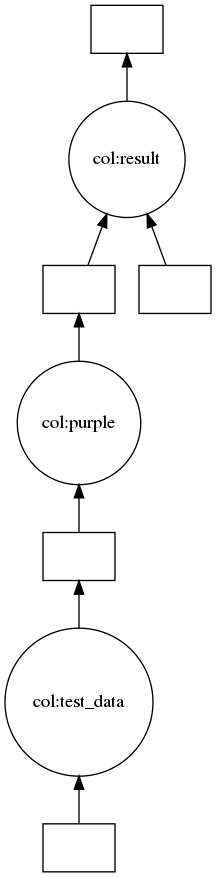

In [13]:
import dask
from dask.optimization import cull, inline

dask.visualize(dsk)

In [16]:
# dask.get(dsk, [add_col_string('result')])
def dask_get(dsk, keys):
    dsk, dependencies = cull(dsk, keys)
    dsk = inline(dsk, dependencies=dependencies)
    return dask.local.get_sync(dsk, keys)

dask_get(dsk, [add_col_string('result')])

INPUT thingamabobs
COUNT 1001
EXECUTE [{'$match': {'foo': 'bar'}}, {'$out': 'test_data'}]
OUTPUT test_data
RESULTS 214
INPUT test_data
COUNT 214
EXECUTE [{'$match': {'color': 'purple'}}, {'$out': 'purple'}]
OUTPUT purple
RESULTS 48
INPUT purple
COUNT 48
EXECUTE [{'$match': {'random': 'PUPPIES'}}, {'$lookup': {'from': 'stuff', 'localField': 'color', 'foreignField': 'color', 'as': 'thingamabob'}}, {'$out': 'result'}]
OUTPUT result
RESULTS 0


('result',)